In [1]:
import sys
import glob
sys.path.append(glob.glob('/home/*/Dropbox/TY_scripts/')[0])
from TY_stats import *
import os
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statannot import add_stat_annotation
import colorcet as cc
import matplotlib.patches as mpatches
from patsy import ModelDesc
from statsmodels.formula.api import ols

%matplotlib inline

sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

#VARIABLES
BIG = '/home/meco/Big_data/RUSITEC/16S_2020'
TABS = 'Data/Tables/'
META = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
DOMS = ['Archaea', 'Bacteria']

ALPHAS = {
    'shannon': 'Shannon entropy', 
    'observed_features': 'Observed features',
    'faith_pd': 'Faith\'s PD',
    'evenness': 'Pielou\'s evenness'}

STYPES = {
    'RSP': 'RSP', 
    'RF': 'RF',
    'E': 'Effluent',
    'FL': 'Fermenter liquid', 
    'FR': 'Feed residue'}

BETAS = {
    'aitchison': 'Aitchison', 
    'bray_curtis': 'Bray-Curtis'}

MDICT = {
    'RF': 'd', 'RSP': 's', 
    'E': '^', 
    'FL': 'p', 
    'FR': 'X'}

CDICT = {'TMR': 'grey',
         'AN1': 'limegreen',
         'AN2': 'green',
         'AT': 'red',
         'FV1': 'deepskyblue',
         'FV2': 'blue',
         'NoT': 'whitesmoke'}

# HGT and RUSITEC, Total Gas and CH4

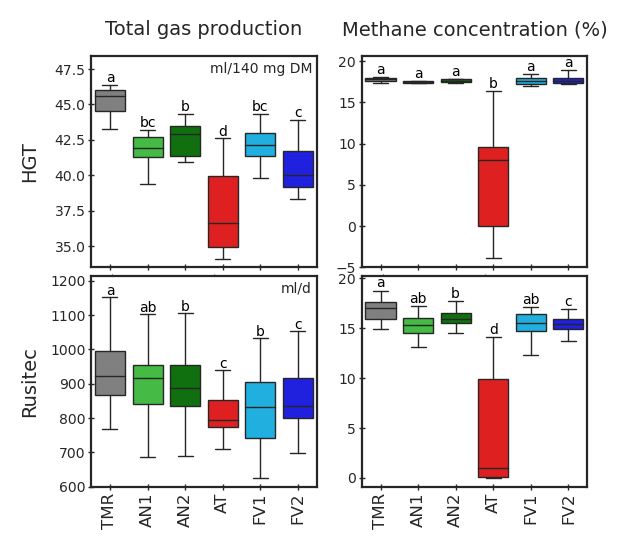

In [2]:
!mkdir -p Figures/TG_CH4

leg = {
    'Tot_gas': 'Total gas',
    'CH4_ml': 'CH4'}

#read data and sign. letters
hgt = pd.read_csv('Descriptions/HGT.tsv', sep='\t')
rst = pd.read_csv('Descriptions/Data Rusitec 2020.csv', sep='\t', skiprows=1)
rst = rst.loc[rst.CH4_p != '.']

ch4_hgt_pc = {
    'TMR': 'a',
    'AN1': 'a', 
    'AN2': 'a',
    'AT': 'b',
    'FV1': 'a',
    'FV2': 'a'}

tg_hgt_ml = {
    'TMR': 'a',
    'AN1': 'bc',
    'AN2': 'b',
    'AT': 'd',
    'FV1': 'bc',
    'FV2': 'c'}

ch4_rst_pc = {
    'TMR': 'a',
    'AN1': 'ab',
    'AN2': 'b',
    'AT': 'd',
    'FV1': 'ab',
    'FV2': 'c'}

tg_rst_ml = {
    'TMR': 'a',
    'AN1': 'ab',
    'AN2': 'b',
    'AT': 'c',
    'FV1': 'b', 
    'FV2': 'c'}

order = ['TMR', 'AN1', 'AN2', 'AT', 'FV1', 'FV2']

#figure and axes
fig, axes = plt.subplots(2, 2, figsize=(3.2, 2.8), sharex='row',
                         gridspec_kw={'wspace': .2, 'hspace': .04})
axs, i = [[r, c] for r in range(2) for c in range(2)], 0

for exp in 'HGT', 'Rusitec':
    data = rst.copy()
    yax = 'ml/d'
    pc_c = ch4_rst_pc
    ml_g = tg_rst_ml
    if exp == 'HGT': 
        data = hgt.copy()
        yax = 'ml/140 mg DM'
        pc_c = ch4_hgt_pc
        ml_g = tg_hgt_ml
    data[['Tot_gas', 'CH4_p']] = data[['Tot_gas', 'CH4_p']].apply(pd.to_numeric)
    for unit in 'ml', 'pc':
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
        if unit == 'pc':
            df = data.copy()
            sns.boxplot(x='algae', y='CH4_p', data=df, ax=ax, linewidth=0.5, showfliers=False,
                        order=order, palette=CDICT)
            #get upper whiskers and add letters for methane concentration
            whishi = [mpl.cbook.boxplot_stats(data.loc[data.algae==t]['CH4_p'])[0]['whishi'] for t in pc_c]
            [ax.text(x, y*1.02, pc_c[order[x]], size=5, ha='center', color='black')\
             for x, y in enumerate(whishi)]
        if unit == 'ml':
            temp = pd.melt(data.copy(), id_vars='algae', value_vars=['Tot_gas'])
            sns.boxplot(x='algae', y='value', data=temp, ax=ax, linewidth=.5, showfliers=False, 
                        order=order, palette=CDICT)
            #get upper whiskers and add letters
            whishi = [mpl.cbook.boxplot_stats(data.loc[data.algae==t]['Tot_gas'])[0]['whishi'] for t in pc_c]
            [ax.text(x, y*1.005, ml_g[order[x]], size=5, ha='center', color='black')\
             for x, y in enumerate(whishi)]
            ax.text(.98, .92, yax, size=5, transform=ax.transAxes, ha='right')
            #legend
            handles, labels = ax.get_legend_handles_labels()
            labels = [leg[l] for l in labels]
            ax.legend(handles,labels, fontsize=5, frameon=False, handletextpad=0.2, handlelength=0.5,
                                bbox_transform=ax.transAxes, bbox_to_anchor=(0,.55), loc=2)
        #aesthetics
        ax.tick_params(axis='both', labelsize=5, length=2, pad=1, width=0.5, direction='inout')
        ax.tick_params(axis='x', labelsize=6, rotation=90)
        ymin, ymax = ax.get_ylim()
        ax.set_ylim([ymin, ymax*1.03])
        ax.set_xlabel('', fontsize=7, labelpad=3)
        if unit=='pc' and exp == 'HGT': 
            ax.text(.5, 1.1, 'Methane concentration (%)', ha='center', fontsize=7, transform=ax.transAxes)
        if unit=='ml' and exp == 'HGT': 
            ax.text(.5, 1.1, 'Total gas production', ha='center', fontsize=7, transform=ax.transAxes)
        ax.set_ylabel('')
        if unit == 'ml':
            ax.set_ylabel(exp, fontsize=7)    
fig.align_labels()
plt.savefig('Figures/TG_CH4/TG-CH4c_HGT-RSTC.png', bbox_inches='tight', facecolor='w')